Prepare Metadata and check Eigenstrat from Olalde 19

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.colors as cls
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

### To load Eigenstrat  
sys.path.append("./PackagesSupport/loadEigenstrat/")  # Since now we are in the Root Directory
from loadEigenstrat import EigenstratLoad

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


# Prepare Meta
Only extract raws that are actually in Eigenstrat

In [11]:
def process_olalde_meta(path_meta_raw = "./Data/Olalde19/meta_raw.csv", 
                        path_es = "./Data/Olalde19/Olalde_et_al_genotypes",
                        save_path = "./Data/Olalde19/meta_processed.csv", bp=True):
    """path_meta_raw: Where to find raw Meta
    path_es: Wherre to find 3 Eigenstrat files (base path before .ind)
    save_path: Where to save the new Meta to"""
    df_raw = pd.read_csv(path_meta_raw, sep="\t")
    print(f"Loaded {len(df_raw)} Individuals from {path_meta_raw}")

    rename_dict = {"Ind ID (_d, only sequences with aDNA damage were used for analysis)":"iid",
                  "Date (Direct radiocarbon date on the individual calibrated at 2 sigma or date range based on the archaeological context)":"age_range",
                   "Latitude":"lat", "Longitude":"lon",
                   "Pop name (NE_Iberia, northeast Iberia; SE_Iberia, southeast Iberia; NW_Iberia, northwest Iberia; SW_Iberia, southwest Iberia; N_Iberia, northern Iberia; C_Iberia, central Iberia; E_Iberia, eastern Iberia; Meso, Mesolithic; EN, Early Neolithic; MLN, Middle-Late Neolithic; CA, Copper Age; Stp, steppe ancestry; Afr, African ancestry; BA, Bronze Age; IA, Iron Age; Hel, Hellenistic; RomP, Roman Period; c.; century; .SG, shotgun data; out, genetic outlier)":"clst",
                   'Autosomal SNPs covered':"n_cov_snp"
                  }

    df_raw.rename(columns=rename_dict, inplace=True)
    df_raw["study"]="Olalde2019"
    df_raw["include_alt"] = (df_raw["Include in genome-wide analyses"] == "Yes")
    df_raw["mean_cov"]=df_raw["n_cov_snp"]/1.2e6
    df_raw["age"]=np.nan ### Implement this
    df_full = df_raw[["iid", "lat", "lon", "age", "age_range", "study", "clst", "mean_cov", "n_cov_snp", "include_alt"]]
            
    ### Extract only raws in Eigenstrat
    df_full = extract_only_eigenstrat(df_full, path_es = path_es)  
    
    df_full=modifiy_age_olalde(df_full, bp=bp) # Modify Age
    
    df_full = fix_coordinates_iberia(df_full)  # Fix samples that are not where they should be
    
    ### Save Dataframe
    if len(save_path)> 0:
        df_full.to_csv(save_path, index=None)  # sep='\t' would not work with downstream analysis
        print(f"Saved {len(df_full)} Individuals to {save_path}")
    return df_full

def extract_only_eigenstrat(df, path_es):
    """Extract only raws of df that are found in .ind file at path_es
    df: Dataframe with iid column. path_es: Eigenstrat basepath"""
    es_load = EigenstratLoad(base_path=path_es)
    df_ind = es_load.df_ind  # Get the Individual List
    idx = df["iid"].isin(df_ind["iid"])
    print(f"Found {np.sum(idx)}/{len(df_ind)} Individuals of Eigenstrat")
    df_found = df[idx]
    return df_found

def modifiy_age_olalde(df, bp=True):
    """Modify dataframe with age_range column.
    Process it and add age column"""
    age = df["age_range"]
    bce = age.str.contains("BCE")  # Whether BCE
    age = age.str.replace(" - ", "-")
    age = df["age_range"].str.replace("–", "-")
    age = age.str.split(r"\s+")
    
    num_age = age.str[0].str.split("-")
    mean_age = (num_age.str[0].astype("float") + num_age.str[1].astype("float"))/2.0
    mean_age[~bce] =  mean_age[~bce] * (-1) # Flip Age for not BCE
    df["age"] = mean_age + bp*1950
    return df

def fix_coordinates_iberia(df):
    """Fix coordinates that are not where they are supposed to be
    Modifies dataframe df with lat / lon field"""
    idx = df["lon"]>8 ### Definitely not in Iberia
    iids = df["iid"][idx].values
    print(f"Fixing {np.sum(idx)} samples with Longitude too big: {iids}")
    df.loc[idx,"lon"] = -df.loc[idx,"lon"]
    return df

In [12]:
%%time
df_full = process_olalde_meta(path_meta_raw = "./Data/Olalde19/meta_raw.csv",
                              path_es = "./Data/Olalde19/Olalde_et_al_genotypes",
                              save_path = "./Data/Olalde19/meta_processed.csv")

Loaded 403 Individuals from ./Data/Olalde19/meta_raw.csv
3 Eigenstrat Files with 278 Individuals and 1233013 SNPs
Found 278/278 Individuals of Eigenstrat
Fixing 2 samples with Longitude too big: ['I11614' 'I11592']
Saved 278 Individuals to ./Data/Olalde19/meta_processed.csv
CPU times: user 8.08 s, sys: 361 ms, total: 8.44 s
Wall time: 8.44 s


# Check Eigenstrat

In [9]:
es_load = EigenstratLoad(base_path="./Data/Olalde19/Olalde_et_al_genotypes")

3 Eigenstrat Files with 278 Individuals and 1233013 SNPs


# Area 51
test code here

In [6]:
## Identify the two samples that need being flipped

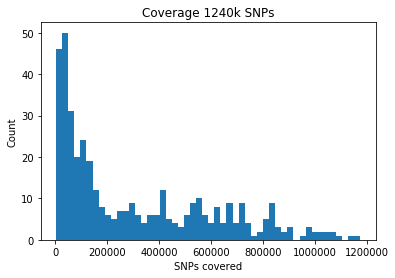

In [44]:
plt.figure()
plt.hist(df_full["n_cov_snp"], bins=50)
plt.title("Coverage 1240k SNPs")
plt.xlabel("SNPs covered")
plt.ylabel("Count")
plt.show()